In [ ]:
import pandas as pd
import os
import glob
import requests
import hashlib
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
from urllib.parse import urlparse
from concurrent.futures import ThreadPoolExecutor, as_completed

# ==== BƯỚC 1: Đọc toàn bộ CSV từ thư mục ====
def read_all_csv_in_folder(folder_path):
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    dfs = []
    for file in all_files:
        df = pd.read_csv(file)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# ==== BƯỚC 2: Tiền xử lý dữ liệu ====
def preprocess_df(df):
    df = df[['article_url', 'article_title', 'article_description', 'clickbait_level']].copy()
    df['label'] = df['clickbait_level'].apply(lambda x: 0 if x in [1, 2] else 1)
    return df

# ==== BƯỚC 3: Tạo tên file ảnh duy nhất ====
def safe_filename_from_url(url):
    h = hashlib.md5(url.encode()).hexdigest()
    return f"{h}.jpg"

# ==== BƯỚC 4: Crawl thumbnail từ HTML ====
def extract_thumbnail_from_html(url):
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=3)
        soup = BeautifulSoup(response.text, "html.parser")
        og_image = soup.find("meta", property="og:image")
        if og_image and og_image.get("content"):
            return og_image["content"]
        first_img = soup.find("img")
        if first_img and first_img.get("src"):
            return first_img["src"]
    except Exception as e:
        print(f"[Thumbnail HTML Error] {url}: {e}")
    return None

# ==== BƯỚC 5: Tải và resize ảnh ====
def download_and_resize_image(image_url, save_dir):
    try:
        os.makedirs(save_dir, exist_ok=True)
        response = requests.get(image_url, timeout=3)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img = img.resize((200, 200))
        filename = safe_filename_from_url(image_url)
        save_path = os.path.join(save_dir, filename)
        img.save(save_path, format="JPEG")
        return save_path
    except Exception as e:
        print(f"[Download Error] {image_url}: {e}")
        return None

# ==== BƯỚC 6: Worker đa luồng cho từng URL ====
def process_single_article(url, save_dir):
    image_url = extract_thumbnail_from_html(url)
    if image_url:
        local_path = download_and_resize_image(image_url, save_dir)
    else:
        local_path = None
    return url, local_path

# ==== BƯỚC 7: Tổng hợp toàn bộ pipeline ====
def process_articles_from_folder(folder_path):
    df = read_all_csv_in_folder(folder_path)
    df = preprocess_df(df)

    thumbnail_dir = "/content/drive/MyDrive/Colab Notebooks/NLP/project/thumbnail"
    results = {}

    # ==== Đa luồng crawl ảnh ====
    with ThreadPoolExecutor(max_workers=10) as executor:
        future_to_url = {executor.submit(process_single_article, url, thumbnail_dir): url for url in df['article_url']}
        for future in as_completed(future_to_url):
            url, thumbnail_path = future.result()
            results[url] = thumbnail_path

    # ==== Gán lại cột thumbnail ====
    df['thumbnail'] = df['article_url'].map(results)

    # ==== Ghi ra file CSV ====
    df_out = df[['article_url', 'article_title', 'article_description', 'thumbnail', 'label']]
    output_path = "/content/drive/MyDrive/Colab Notebooks/NLP/project/processed_update_articles.csv"
    df_out.to_csv(output_path, index=False)
    return df_out

process_articles_from_folder("/content/drive/MyDrive/Colab Notebooks/NLP/project")

**Chạy từ đây**

In [ ]:
import pandas as pd

# Đọc lại file đã cập nhật
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/project/processed_update_articles.csv")

# Điều kiện: cả 3 cột đều không NaN và không rỗng
df_full_rows = df[
    df['article_title'].notna() & (df['article_title'].str.strip() != "") &
    df['article_description'].notna() & (df['article_description'].str.strip() != "") &
    df['thumbnail'].notna() & (df['thumbnail'].str.strip() != "")
]

print(f"Số dòng đầy đủ cả 3 thuộc tính: {len(df_full_rows)} / {len(df)}")
df_full_rows.to_csv("/content/drive/MyDrive/Colab Notebooks/NLP/project/cleaned_articles.csv", index=False)


Số dòng đầy đủ cả 3 thuộc tính: 86294 / 86762


In [ ]:
df_full_rows.head()

,article_url,article_title,article_description,thumbnail,label
0,https://www.irishmirror.ie/sport/ufc/conor-mcg...,Why Conor McGregor quickly deletes so many of ...,Conor McGregor has made a bit of a habit of qu...,/content/drive/MyDrive/Colab Notebooks/NLP/pro...,1
1,https://www.thesun.ie/tv/14450756/claudia-wink...,Claudia Winkleman drops big clue over how The ...,CLAUDIA Winkleman has shared a big insight int...,/content/drive/MyDrive/Colab Notebooks/NLP/pro...,0
2,https://www.irishmirror.ie/news/irish-news/jud...,Judge confirms Liam Payne was 'escaping hotel'...,Liam Payne was taken to his room by hotel staf...,/content/drive/MyDrive/Colab Notebooks/NLP/pro...,1
3,https://www.irishmirror.ie/news/irish-news/iri...,Lucky Irish Lotto player scoops €1 million pri...,"Along with the €1 million prize winner, six lu...",/content/drive/MyDrive/Colab Notebooks/NLP/pro...,0
4,https://www.irishmirror.ie/news/weird-news/nos...,Nostradamus' terrifying predictions for 2025 -...,The famous astrologer Nostradamus predicted a ...,/content/drive/MyDrive/Colab Notebooks/NLP/pro...,1


In [ ]:
sum_45 = df_merged[df_merged['clickbait_level'].isin([4, 5])].shape[0]
print("Tổng số record có clickbait_level là 4 hoặc 5:", sum_45)

Tổng số record có clickbait_level là 4 hoặc 5: 8613


In [ ]:
# Lấy toàn bộ dòng có clickbait_level 4 hoặc 5
df_45 = df_merged[df_merged['clickbait_level'].isin([4, 5])]

# Lấy ngẫu nhiên sum_45 dòng từ level 1
df_1_sampled = df_merged[df_merged['clickbait_level'] == 1].sample(n=sum_45, random_state=42)

# Kết hợp lại thành new_df
new_df = pd.concat([df_45, df_1_sampled], ignore_index=True)

# Giữ lại các dòng trong new_df mà article_url có trong df_full_rows
merged_df = new_df.merge(df_full_rows, on="article_url", how="inner")


In [ ]:
merged_df.columns.tolist()

['article_url',
 'article_title_x',
 'article_description_x',
 'clickbait_level',
 'article_title_y',
 'article_description_y',
 'thumbnail',
 'label']

In [ ]:
final_df = merged_df[['article_url', 'article_title_y', 'article_description_y', 'thumbnail', 'label']]
df_full_rows = final_df.copy()

In [ ]:
#final_df.to_csv("/content/drive/MyDrive/Colab Notebooks/NLP/project/cleaned_articles.csv", index=False)

# Điều kiện: cả 3 cột đều không NaN và không rỗng
df_full_rows = df_full_rows[
    df['article_title'].notna() & (df['article_title'].str.strip() != "") &
    df['article_description'].notna() & (df['article_description'].str.strip() != "") &
    df['thumbnail'].notna() & (df['thumbnail'].str.strip() != "")
]

print(f"Số dòng đầy đủ cả 3 thuộc tính: {len(df_full_rows)} / {len(df_full_rows)}")

# Đếm số lượng mỗi giá trị trong cột label
label_counts = df_full_rows['label'].value_counts().sort_index()

# In kết quả
print("Thống kê số lượng label:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} mẫu")

Số dòng đầy đủ cả 3 thuộc tính: 17051 / 17051
Thống kê số lượng label:
Label 0: 8551 mẫu
Label 1: 8500 mẫu


/tmp/ipython-input-28-3649447135.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_full_rows = df_full_rows[


In [ ]:
df_full_rows = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/project/cleaned_articles.csv")
df_train, df_val, df_test = split_dataset(df_full_rows)

# ***Multimodal Soft-prompt Tuning Few-shot Classification with Ensemble Learning***

In [ ]:
#1
!pip install torch_geometric tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/63.1 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.7 MB/s eta 0:00:00


In [ ]:
#2
# msp_pipeline.py
"""
Multimodal Soft Prompt Tuning (Few-shot + Ensemble + Ablation) – 9-step pipeline
• Self-contained: chỉ cần DataFrame `df_full_rows` (các cột: article_title,
  article_description, thumbnail, label ∈ {0,1}) + GPU/Torch.
"""

# ===== 0. Imports =====
import os, random, numpy as np, pandas as pd, torch, torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, precision_recall_curve, auc)
from transformers import (RobertaTokenizer, RobertaModel,
                          RobertaForMaskedLM, CLIPModel)
from torch_geometric.nn import GATConv
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from transformers.utils import logging
logging.set_verbosity_error()
import gc


# ===== 1. Data Preparation =====
def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
    df_full_rows = df[
                      df['article_title'].notna() & (df['article_title'].str.strip() != "") &
                      df['article_description'].notna() & (df['article_description'].str.strip() != "") &
                      df['thumbnail'].notna() & (df['thumbnail'].str.strip() != "")
                    ].copy()
    return df_full_rows

def split_dataset(df: pd.DataFrame, seed=42):
    df_trainval, df_test = train_test_split(df, test_size=0.1, stratify=df.label, random_state=seed)
    df_train, df_val = train_test_split(df_trainval, test_size=2/9, stratify=df_trainval.label, random_state=seed)
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)

# ===== 2. Few-shot Sampler =====
def sample_k_shot(df: pd.DataFrame, k: int, seed: int) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    return (
        df.groupby("label", group_keys=False)
          .apply(lambda x: x.sample(n=k, random_state=rng.integers(1e6)).assign(label=x.name),
                 include_groups=False)
          .reset_index(drop=True)
    )

# ===== 3. Dataset & Dataloaders =====
class ClickbaitDataset(Dataset):
    def __init__(self, df, tokenizer, img_tf):
        self.df, self.tok, self.tf = df.reset_index(drop=True), tokenizer, img_tf
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        r = self.df.loc[idx]
        toks = self.tok(r.article_title, r.article_description,
                        padding='max_length', truncation=True,
                        max_length=128, return_tensors='pt')
        try:
            img = Image.open(r.thumbnail).convert('RGB')
        except:                           # nếu lỗi ảnh ⇒ ảnh đen
            img = Image.new('RGB', (224, 224), (0, 0, 0))
        return {"input_ids": toks.input_ids.squeeze(0),
                "attention_mask": toks.attention_mask.squeeze(0),
                "image": self.tf(img),
                "label": torch.tensor(r.label, dtype=torch.float),
                "title": r.article_title}

def create_dataloader(df, tokenizer, transform, bs, shuffle=True, drop_last=True):
    dataset = ClickbaitDataset(df, tokenizer, transform)
    return DataLoader(dataset, batch_size=bs, shuffle=shuffle, drop_last=drop_last, num_workers=8, pin_memory=True)

# ===== 4. Base Blocks =====
# 4-a) Syntactic encoder (GAT over dependency graph)
nlp = spacy.load("en_core_web_sm")
POS2IDX = {t: i for i, t in enumerate(nlp.get_pipe("tagger").labels)}

class SyntacticEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(len(POS2IDX), 128)
        self.gat = GATConv(128, 256)
        self.elu = nn.ELU()
        self.project = nn.Linear(256, 768)

    def forward(self, titles):
        device = next(self.parameters()).device
        feats = []
        for text in titles:
            doc = nlp(text)
            edge_index = torch.tensor([(t.i, c.i) for t in doc for c in t.children] or [(0, 0)],
                                      dtype=torch.long).t().to(device)
            pos_ids = torch.tensor([POS2IDX.get(t.tag_, 0) for t in doc], dtype=torch.long).to(device)
            x = self.embedding(pos_ids)
            x = self.gat(x, edge_index)
            x = self.elu(x)
            feats.append(self.project(x.mean(0)))
        return torch.stack(feats)

# 4-b) Soft prompt helper
class SoftPrompt(nn.Module):
    def __init__(self, n, d): super().__init__(); self.p = nn.Parameter(torch.randn(n, d))
    def forward(self, b): return self.p.unsqueeze(0).expand(b, -1, -1)

# 4-c) Prompted text encoder (Roberta-MLM)
class PromptedText(nn.Module):
    def __init__(self, prompt=True):
        super().__init__()
        self.base = RobertaForMaskedLM.from_pretrained('roberta-large') if prompt \
                    else RobertaModel.from_pretrained('roberta-large')
        self.p_len = 5 if prompt else 0
        self.prompt = SoftPrompt(self.p_len, self.base.config.hidden_size) if prompt else None
    def forward(self, ids, mask):
        if self.prompt is None: return self.base(ids, attention_mask=mask).last_hidden_state.mean(1)
        embeds = self.base.roberta.embeddings.word_embeddings(ids)
        p = self.prompt(embeds.size(0))
        embeds = torch.cat([p, embeds], 1)
        m = torch.cat([torch.ones(ids.size(0), self.p_len, device=ids.device), mask], 1)
        out = self.base.roberta(inputs_embeds=embeds, attention_mask=m)
        return (out.last_hidden_state * m.unsqueeze(-1)).sum(1) / (m.sum(1, keepdim=True) + 1e-9)

# 4-d) Prompted image encoder
class PromptedImage(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        dim = self.base.vision_model.config.hidden_size
        self.prompt = SoftPrompt(5, dim)
        self.conv = nn.Sequential(nn.Conv1d(dim, 256, 1), nn.ReLU(),
                                  nn.AdaptiveAvgPool1d(1))
        self.out = nn.Linear(256, 768)
    def forward(self, img):
        hid = self.base.vision_model(pixel_values=img).last_hidden_state     # [b, seq, d]
        p = self.prompt(hid.size(0)).mean(1).unsqueeze(1)
        h = torch.cat([p, hid], 1).transpose(1, 2)                           # [b, d, seq+1]
        return self.out(self.conv(h).squeeze(-1))

# 4-e) Loss helpers
class FocalLoss(nn.Module):
    def __init__(s, a=1.0, g=2.0): super().__init__(); s.a, s.g = a, g
    def forward(s, logit, y):
        bce = nn.functional.binary_cross_entropy_with_logits(logit, y, reduction='none')
        pt = torch.exp(-bce); return (s.a * (1 - pt)**s.g * bce).mean()

def get_balanced_bce(df, device):
    pos, neg = (df.label == 1).sum(), (df.label == 0).sum()
    return nn.BCEWithLogitsLoss(pos_weight=torch.tensor([neg/pos]).to(device))

# ===== 5. Build variant model factory =====
def build_model(fusion='concat', prompt=True, loss='focal', df_train=None, device='cuda'):
    class MSP(nn.Module):
        def __init__(self):
            super().__init__()
            self.txt = PromptedText(prompt)
            self.img = PromptedImage()
            self.syn = SyntacticEncoder()
            self.tp, self.ip, self.sp = nn.Linear(self.txt.base.config.hidden_size, 256),\
                                        nn.Linear(768, 256), nn.Linear(768, 256)
            if fusion == 'concat':
                self.fuse = nn.Sequential(nn.Linear(256*3, 512), nn.ReLU(),
                                          nn.Dropout(0.3), nn.Linear(512, 1))
            else:                       # gated
                self.gate = nn.Sequential(nn.Linear(256 * 3, 256 * 3), nn.Sigmoid())
                self.fuse = nn.Sequential(nn.Linear(256 * 3, 128), nn.ReLU(),
                                          nn.Dropout(0.3), nn.Linear(128, 1))
        def forward(self, ids, mask, img, titles):
            t = self.tp(self.txt(ids, mask))
            i = self.ip(self.img(img))
            s = self.sp(self.syn(titles))
            cat = torch.cat([t, i, s], 1)
            if fusion == 'concat': out = self.fuse(cat)
            else: out = self.fuse(self.gate(cat) * cat)
            return out.squeeze(-1)
    if loss == 'focal':
        loss_fn = FocalLoss()
    elif loss == 'bce':
        loss_fn = get_balanced_bce(df_train, device)
    else:
        raise ValueError(f"Unsupported loss: {loss}")

    return MSP(), loss_fn

# ===== 6. Variant Train hyper-params =====
VARIANTS = [
    {'bs': 24, 'lr': 5e-4, 'fusion': 'gated',  'loss': 'focal'},
    {'bs': 32, 'lr': 5e-4, 'fusion': 'concat', 'loss': 'focal'},
    {'bs': 32, 'lr': 2e-4, 'fusion': 'gated',  'loss': 'focal'},
    {'bs': 32, 'lr': 5e-4, 'fusion': 'gated',  'loss': 'bce'},
    {'bs': 32, 'lr': 2e-4, 'fusion': 'gated',  'loss': 'focal'},
]
def train_variant(i, df_train, df_val, tok, tfm, dev, save_dir="/content/drive/MyDrive/Colab Notebooks/NLP/project/"):
    os.makedirs(save_dir, exist_ok=True)
    config = VARIANTS[i]
    print(f"Training variant {i}: {config} | ")

    tr_loader = create_dataloader(df_train, tok, tfm, config['bs'], shuffle=True, drop_last=True)
    va_loader = create_dataloader(df_val, tok, tfm, config['bs'], shuffle=False, drop_last=False)

    model, loss_fn = build_model(fusion=config['fusion'], prompt=True, loss=config['loss'],
                                 df_train=df_train, device=dev)
    model.to(dev)
    opt = torch.optim.AdamW(model.parameters(), lr=config['lr'])

    for epoch in range(3):
        model.train()
        loop = tqdm(tr_loader, desc=f"Epoch {epoch+1}/{3}", leave=True)
        for b in loop:
            opt.zero_grad()
            l = model(b['input_ids'].to(dev),
                      b['attention_mask'].to(dev),
                      b['image'].to(dev),
                      b['title']).to(dev)
            loss = loss_fn(l, b['label'].to(dev))
            loss.backward()
            opt.step()
            loop.set_postfix(loss=loss.item())

    # Validation
    model.eval()
    preds, labels = [], []
    for b in tqdm(va_loader, desc=f"Validating...", leave=True):
        with torch.no_grad():
            p = model(b['input_ids'].to(dev),
                      b['attention_mask'].to(dev),
                      b['image'].to(dev),
                      b['title']).sigmoid().cpu()
        preds.append(p)
        labels.append(b['label'])

    pred = (torch.cat(preds) > 0.5).int()
    true = torch.cat(labels)
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred)
    print(f" - val_acc={acc:.4f}, f1={f1:.4f}")

    torch.save(model.state_dict(), os.path.join(save_dir, f"variant_{i}.pt"))
    return acc, f1

def load_models(idxs: list, df_train, device='cuda', save_dir="/content/drive/MyDrive/Colab Notebooks/NLP/project/"):
    models = []
    for i in idxs:
        config = VARIANTS[i]
        model, _ = build_model(fusion=config['fusion'], prompt=True, loss=config['loss'],
                               df_train=df_train, device=device)
        model.load_state_dict(torch.load(os.path.join(save_dir, f"variant_{i}.pt"), map_location=device))
        model.to(device)
        model.eval()
        models.append(model)
    return models

# ===== 7. Full Test - Ensemble =====
def full_eval_run(df_test, models, weights, tok, tfm, dev, bs):
    print(f"Running full-set ensemble evaluation...")
    te_loader = create_dataloader(df_test, tok, tfm, bs=bs, shuffle=False, drop_last=False)
    probs = []

    for i, m in enumerate(models):
        m.eval()
        pred = []
        for b in tqdm(te_loader, desc=f"Model {i}/{len(models)-1}", leave=False):
            with torch.no_grad():
                p = m(b['input_ids'].to(dev),
                      b['attention_mask'].to(dev),
                      b['image'].to(dev),
                      b['title']).sigmoid().cpu()
            pred.append(p)
        probs.append(torch.cat(pred))

    # Hard voting
    bin_preds = [(p > 0.5).int() for p in probs]
    votes = sum(p * w for p, w in zip(bin_preds, weights))
    pred = (votes > 0.5).int()

    # Ground-truth
    y = torch.cat([b['label'] for b in te_loader])

    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    rc = recall_score(y, pred)

    # Soft-voting for PR AUC
    soft_final = sum(p * w for p, w in zip(probs, weights))
    pr, rc_curve, _ = precision_recall_curve(y, soft_final)
    pr_auc = auc(rc_curve, pr)

    print(f"  Full-set → acc={acc:.4f}, f1={f1:.4f}, recall={rc:.4f}, PR-AUC={pr_auc:.4f}")
    return dict(acc=acc, f1=f1, recall=rc, pr_auc=pr_auc)

# ===== 8. Few-shot run + logging =====
def fewshot_run(fewshot_df, models, weights, k, tok, tfm, dev, bs):
    print(f"Running few-shot experiment with k={k}")
    te_loader = create_dataloader(fewshot_df, tok, tfm, bs=bs, shuffle=False, drop_last=False)
    probs = []

    for i, m in enumerate(models):
        m.eval()
        pred = []
        for b in tqdm(te_loader, desc=f"Model {i}/{len(models)-1}", leave=True):
            with torch.no_grad():
                p = m(b['input_ids'].to(dev),
                      b['attention_mask'].to(dev),
                      b['image'].to(dev),
                      b['title']).sigmoid().cpu()
            pred.append(p)
        probs.append(torch.cat(pred))

    bin_preds = [(p > 0.5).int() for p in probs]
    votes = sum(p * w for p, w in zip(bin_preds, weights))
    final = (votes > 0.5).int()
    pred = (final > 0.5).int()
    y = torch.cat([b['label'] for b in te_loader])

    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    rc = recall_score(y, pred)
    soft_final = sum(p * w for p, w in zip(probs, weights))
    pr, rc_curve, _ = precision_recall_curve(y, soft_final)
    pr_auc = auc(rc_curve, pr)

    print(f"  k={k} → acc={acc:.4f}, f1={f1:.4f}")
    return dict(k=k, acc=acc, f1=f1, recall=rc, pr_auc=pr_auc)



# ===== 10. Visualization helpers (bước 9) =====
def plot_results(results_df):
    # ---- Biểu đồ cột nhóm: acc và f1 vs. k-shot ----
    plt.figure(figsize=(7, 5))

    # Chuyển đổi dữ liệu sang dạng "long" cho dễ vẽ grouped bar
    df_melt = results_df.melt(id_vars='k', value_vars=['acc', 'f1'],
                              var_name='Metric', value_name='Score')

    sns.barplot(x='k', y='Score', hue='Metric', data=df_melt)
    plt.title("Accuracy & F1 vs. k-shot")
    plt.xlabel("k-shot (samples per class)")
    plt.ylabel("Score")
    plt.ylim(0, 1.0)
    plt.legend(title="Metric")
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()




# ===========================


In [ ]:
#3
df_train = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/NLP/project/df_train.pkl")
df_val = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/NLP/project/df_val.pkl")
df_test = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/NLP/project/df_test.pkl")

**Train Variants**

In [ ]:
#4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
img_tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
#5
train_variant(0, df_train, df_val, tokenizer, img_tf, device)
#need re-train

Training variant 0: {'bs': 24, 'lr': 0.0005, 'fusion': 'gated', 'loss': 'focal'} | 


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]


Epoch 1/3:   0%|          | 0/497 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Validating...: 100%|██████████| 143/143 [04:59<00:00,  2.10s/it]


 - val_acc=0.7997, f1=0.8019


(0.7997067448680352, 0.8018566869741804)

In [ ]:
#6
train_variant(1, df_train, df_val, tokenizer, img_tf, device)
#need re-train

Training variant 1: {'bs': 32, 'lr': 0.0005, 'fusion': 'concat', 'loss': 'focal'} | 


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]


Validating...: 100%|██████████| 107/107 [03:31<00:00,  1.98s/it]


 - val_acc=0.7974, f1=0.7977


(0.7973607038123167, 0.7976573938506588)

In [ ]:
#7
train_variant(2, df_train, df_val, tokenizer, img_tf, device)
#need re-train

Training variant 2: {'bs': 32, 'lr': 0.0002, 'fusion': 'gated', 'loss': 'focal'} | 


Validating...: 100%|██████████| 107/107 [02:38<00:00,  1.48s/it]


 - val_acc=0.8147, f1=0.8199


(0.8146627565982405, 0.81994301994302)

In [ ]:
#8
train_variant(3, df_train, df_val, tokenizer, img_tf, device)


Training variant 3: {'bs': 32, 'lr': 0.0005, 'fusion': 'gated', 'loss': 'bce'} | 


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]


Epoch 1/3:   0%|          | 0/372 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Validating...: 100%|██████████| 107/107 [06:12<00:00,  3.48s/it]


 - val_acc=0.8082, f1=0.7922


(0.8082111436950147, 0.7922490470139771)

In [ ]:
#9
train_variant(4, df_train, df_val, tokenizer, img_tf, device)


Training variant 4: {'bs': 32, 'lr': 0.0002, 'fusion': 'gated', 'loss': 'focal'} | 


Validating...: 100%|██████████| 107/107 [05:45<00:00,  3.23s/it]


 - val_acc=0.8067, f1=0.8090


(0.8067448680351906, 0.8090408577223993)

**Load các model tốt nhất sau huấn luyện**

In [ ]:
#10
# Sau khi đã train, bạn chọn tay 3 model tốt nhất:
chosen = [2, 3, 4] # change
models = load_models(chosen, df_train, device)

In [ ]:
#11
scores = [0.8147, 0.8082, 0.8067] #acc1, acc2, acc3, acc4, acc5

def softmax(x, tau=0.05  ):
    x = np.array(x)
    e = np.exp(x / tau)
    return e / e.sum()
weights = softmax(scores, tau=0.3)
weights

array([0.33872446, 0.33146436, 0.32981118])

**Eval on Full Test-Dataset**

In [ ]:
#11
#df_test = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/NLP/project/df_test.pkl")

full_eval_run(df_test, models, weights, tokenizer, img_tf, device, bs=32)

Running full-set ensemble evaluation...


  Full-set → acc=0.8283, f1=0.8273, recall=0.8259, PR-AUC=0.9069


{'acc': 0.828253223915592,
 'f1': 0.8273423688862699,
 'recall': 0.8258823529411765,
 'pr_auc': np.float64(0.9069224687695836)}

**Test few-shot**

In [ ]:
#12
results = []
for k in [5, 10, 20]:
    fewshot_df = sample_k_shot(df_test, k=k, seed=42)  # hoặc random seed
    result = fewshot_run(fewshot_df, models, weights, k, tokenizer, img_tf, device, bs=32)
    results.append(result)

results_df = pd.DataFrame(results)
results_df.to_pickle("/content/drive/MyDrive/Colab Notebooks/NLP/project/results_new.pkl")

Running few-shot experiment with k=5


Model 2/2: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


  k=5 → acc=0.8000, f1=0.7500
Running few-shot experiment with k=10


Model 2/2: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


  k=10 → acc=0.8000, f1=0.7778
Running few-shot experiment with k=20


Model 2/2: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


  k=20 → acc=0.8500, f1=0.8421


,k,acc,f1,recall,pr_auc
0,5,0.80,0.750000,0.6,0.938095
1,10,0.80,0.777778,0.7,0.924627
2,20,0.85,0.842105,0.8,0.963949


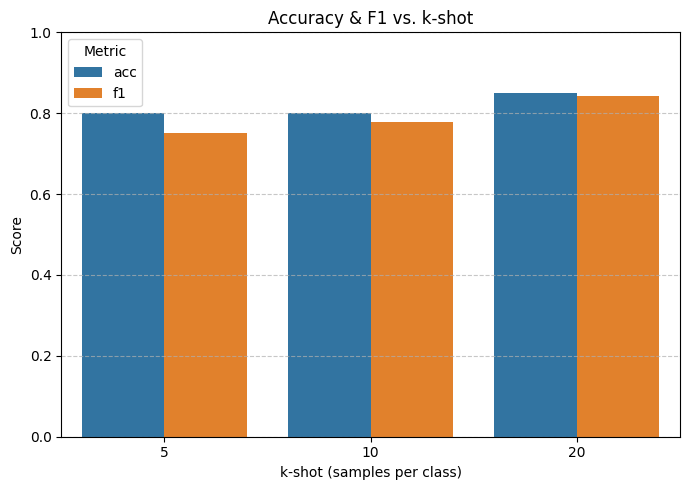

In [ ]:
#13
results_df = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/NLP/project/results_new.pkl")
display(results_df)
plot_results(results_df)

**Test 1 sample**

In [ ]:
df_1row = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/NLP/project/df_test.pkl")

row = df_1row.sample(n=1, random_state=random.randint(0, 99999)).iloc[0]
row

,1309
article_url,https://www.thesun.ie/tv/15009142/country-hous...
article_title,Incredible country house which features in ico...
article_description,A FAMOUS mansion where a hit British TV show w...
thumbnail,/content/drive/MyDrive/Colab Notebooks/NLP/pro...
label,1


In [ ]:
# ---- 1. Tiền xử lý text ----
encoded = tokenizer(
    row['article_title'], row['article_description'],
    padding='max_length', truncation=True,
    max_length=128, return_tensors='pt'
)
input_ids = encoded['input_ids'].to(device)
attention_mask = encoded['attention_mask'].to(device)

# ---- 2. Tiền xử lý ảnh ----
try:
    img = Image.open(row['thumbnail']).convert('RGB')
except:
    img = Image.new('RGB', (224, 224), (0, 0, 0))  # fallback nếu lỗi ảnh
image_tensor = img_tf(img).unsqueeze(0).to(device)

# ---- 3. Chuẩn bị title ----
title = row['article_title']
titles = [title]  # batch dạng list

# ---- 4. Chạy từng model trong ensemble ----
probs = []
for m in models:
    m.eval()
    with torch.no_grad():
        p = m(input_ids, attention_mask, image_tensor, titles).sigmoid().cpu()
        probs.append(p.squeeze(0))  # (1,) → ()

# ---- 5. Voting + Kết quả ----
bin_preds = [(p > 0.5).int() for p in probs]
votes = sum(p * w for p, w in zip(bin_preds, weights))
final_pred = int((votes > 0.5).item())
true_label = int(row['label'])


# Tính voting
bin_preds = [(p > 0.5).int() for p in probs]
votes = sum(p * w for p, w in zip(bin_preds, weights))
final_pred = int((votes > 0.5).item())
true_label = int(row['label'])

# So sánh
print(f"Ground-truth: {true_label}")
print(f"Predicted   : {final_pred}")

Ground-truth: 1
Predicted   : 1
